In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

I need to figure out a way of translating the river mouth locations to the grid from the model. 

Idea:

- Detect the coastal cell that is closer to the river mouth. 
- Create the cluster using that cell. 

In [2]:
def haversine_distance_two(point_A, point_B):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    """
    lat1, lon1 = point_A
    lat2, lon2 = point_B
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def rivers_per_location(DF, loc_coords, radius):
    """
    DF is the River_sources dataframes. loc_coords is the location coordinates.
    radius is the radius of in degrees around loc_coords.
    Returns the dataframe around loc_coords.
    """
    lat, lon = loc_coords
    mask = (DF['X'] <= lon + radius) & (DF['X'] > lon - radius) & (DF['Y'] <= lat + radius) & (DF['Y'] > lat - radius)
    new_DF = DF[mask]
    return new_DF

def region_filters(DF, lon_min, lon_max, lat_min, lat_max):
    """
    DF is the River_sources dataframes. lat_min, lat_max, lon_min, lon_max are the domain limits.
    Returns the dataframe only for the region.
    """
    mask = (DF['X'] <= lon_max) & (DF['X'] > lon_min) & (DF['Y'] <= lat_max) & (DF['Y'] > lat_min)
    new_DF = DF[mask]
    return new_DF

In [3]:
river_sources = pd.read_csv('../data/sources/Lebreton_rivers/PlasticRiverInputs.csv')

In [4]:
coastal_fields = xr.load_dataset('../coastal_fields.nc')

In [5]:
coastal_fields.lon

<xarray.DataArray 'lon' (x: 1176)>
array([-73.      , -72.916664, -72.833336, ...,  24.75    ,  24.833334,
        24.916666], dtype=float32)
Coordinates:
    lon      (x) float32 -73.0 -72.92 -72.83 -72.75 ... 24.67 24.75 24.83 24.92
Dimensions without coordinates: x

In [6]:
coast = coastal_fields.coastal.values
lats = coastal_fields.lat.values
lons = coastal_fields.lon.values

X = coastal_fields.lon_mesh
Y = coastal_fields.lat_mesh

In [20]:
iy_coast, ix_coast = np.where(coast==1)
lat_coast = lats[iy_coast]
lon_coast = lons[ix_coast]

In [38]:
def nearest_coastal_cell(latidute, longitude, coord_lat, coord_lon):    
    """
    Function to find the index of the closest point to a certain lon/lat value.
    
    latidute and longitude are the dimensinal 1D arrays of the grid, with the same length.
    coord_lat and coord_lon are the coordinates of a point.
    """
    
    distance = np.sqrt((longitude-coord_lon)**2 + (latidute-coord_lat)**2)                     
    index = distance.argmin()               
        
    return index

In [29]:
nearest_coastal_cell(lat_coast, lon_coast, -10, -30)

4777

We select a smaller region for the analysis.

In [11]:
South_Atlantic_region = (-70, 25, -50, -5)

In [12]:
SA_rivers = region_filters(river_sources, *South_Atlantic_region)

In [14]:
sorted_rivers = SA_rivers.sort_values('i_high', ascending=False)
sorted_rivers = sorted_rivers.reset_index()

-35.0375 -6.2875
4833
-35.0 -6.3333335


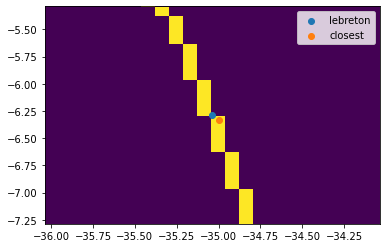

In [39]:
N = 300

x_lon = sorted_rivers.iloc[N].X
x_lat = sorted_rivers.iloc[N].Y

print(x_lon, x_lat)
n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
print(n_index)
print(lon_coast[n_index], lat_coast[n_index])

res = 1
plt.pcolormesh(X,Y, coast,shading='auto')
plt.scatter(x_lon, x_lat, label='lebreton')
plt.scatter(lon_coast[n_index], lat_coast[n_index], label='closest')
plt.xlim(x_lon-res, x_lon+res)
plt.ylim(x_lat-res, x_lat+res)
plt.legend()

In [ ]:
def 

In [79]:
N = 300
coordinates = np.zeros((N, 2))

for i in range(N):
    x_lon = sorted_rivers.iloc[i].X
    x_lat = sorted_rivers.iloc[i].Y

    n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
    coordinates[i,:] = (lon_coast[n_index], lat_coast[n_index])

In [80]:
lons.min(), lons.max()

(-73.0, 24.916666)

In [110]:
hist, _,_ = np.histogram2d(coordinates[:, 0], coordinates[:, 0], bins=coast.shape,
                            range=[[lons.min(), lons.max()], [lats.min(), lats.max()]])

In [111]:
np.sum(hist)

241.0

In [112]:
%matplotlib inline

/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


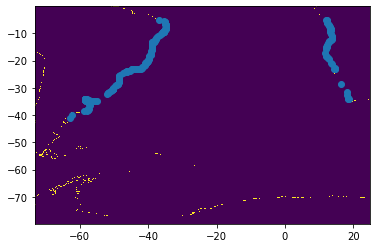

In [114]:
plt.pcolormesh(X, Y, coast)
plt.scatter(coordinates[:,0], coordinates[:, 1])

In [106]:
%matplotlib inline

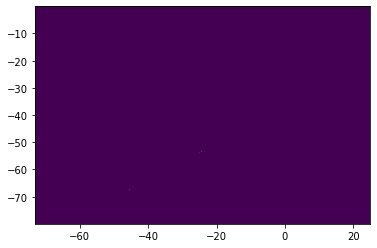

In [107]:
plt.pcolormesh(X, Y, hist, shading='auto')